# **IMPORT LIBS**

## Import

Import standard libraries.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import numpy as np
from openrec.tf1.legacy import ImplicitModelTrainer
from openrec.tf1.legacy.utils.evaluators import ImplicitEvalManager
from openrec.tf1.legacy.utils import ImplicitDataset
from openrec.tf1.legacy.recommenders import CML
from openrec.tf1.legacy.utils.evaluators import AUC
from openrec.tf1.legacy.utils.samplers import PairwiseSampler
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import sys
import os
import numpy as np
import matplotlib.pyplot as plt  

Import our functions.

In [2]:
# Adjusts path to include the utilities.py file
sys.path.append('../')
# Imports it
from helper import *

Set training flag.

In [3]:
# Flag to retrain the model (in this notebook should always be False)
REPEAT_TRAINING = False

# **INITIALIZATION**

## Init

Initialize notebook parameters.

In [4]:
# Set the seed for reproducibility
seed = 2384795
np.random.seed(seed=seed)

Initialize paths.

In [5]:
# Preparing folder for output data
output_name = f"./generated_data/"
if os.path.exists(output_name) == False:
    os.makedirs(output_name)

# **IMPORT DATA**

In this section we will just be using the code provided by the authors of the paper.

## Training set

Load the data of the training set.

In [6]:
# Name of the dataset paths
folder_name = f"./original_files/"
file_path = folder_name + 'big_matrix.csv'

# Load the training set into a DataFrame
df_train = pd.read_csv(file_path) 

Convert it to implicit.

In [7]:
# "We treat items with a watch_ratio greater than or equal to 2 as relevant, and others as irrelevant."
POSITIVE_THRESHOLD = 2.0

# Add column to the DataFrame
df_train['ImplicitRating'] = np.where(df_train['watch_ratio'] > POSITIVE_THRESHOLD, 1, 0)

Check we did it right.

In [8]:
# "The training set contains 12,530,806 ratings given by 7,176 users against 10,728 videos through natural interactions."

# Store the range of ids for users
min_user = df_train["user_id"].min()
max_user = df_train["user_id"].max()

# Store the range of items
min_item = df_train["video_id"].min()
max_item = df_train["video_id"].max()

# Visualize the number of both
max_item, max_user

(10727, 7175)

## Unbiased testset

In [9]:
# Name of the dataset paths
file_path = folder_name + 'small_matrix.csv'

# Load the training set into a DataFrame
df_test = pd.read_csv(file_path)

Convert to implicit.

In [10]:
# Add column to the DataFrame
df_test['ImplicitRating'] = np.where(df_test['watch_ratio'] > POSITIVE_THRESHOLD, 1, 0)

Check number of users and items.

In [11]:
# "The testing set is collected by asking a subset of 1,411 users to rate 3,327 randomly selected songs."

# Visualize
df_test['user_id'].unique().shape[0] , df_test["video_id"].unique().shape[0]

(1411, 3327)

Split into positive and negative.

In [12]:
# From the dataframe, for each row where ImplicitRating is 1, append [userID, itemID] to unbiased_pos_test_set
# and for each row where ImplicitRating is 0, append [userID, itemID] to unbiased_neg_test_set
unbiased_pos_test_set = df_test[df_test["ImplicitRating"] == 1][["user_id", "video_id"]].values
unbiased_neg_test_set = df_test[df_test["ImplicitRating"] == 0][["user_id", "video_id"]].values

And save it.

In [13]:
# Remember to split pos and neg test set into two separate files

# Get the dataframe
unbiased_pos_test_set_df = pd.DataFrame(unbiased_pos_test_set)
unbiased_neg_test_set_df = pd.DataFrame(unbiased_neg_test_set)

# Get couples user-item
unbiased_pos_test_set_df.columns = ["user_id","item_id"]
unbiased_neg_test_set_df.columns = ["user_id","item_id"]

# Turn into records
structured_data_pos_test_set_unbiased = unbiased_pos_test_set_df.to_records(index=False)
structured_data_neg_test_set_unbiased = unbiased_neg_test_set_df.to_records(index=False)

# Save
np.save(output_name + "unbiased-test_arr_pos.npy", structured_data_pos_test_set_unbiased)
np.save(output_name + "unbiased-test_arr_neg.npy", structured_data_neg_test_set_unbiased)

# Biased testset

Extract the biased test set.

In [14]:
# "We additionally held out a biased testing set (biased-testing) from the training set by randomly sampling 30% songs for each user."

# Precompute, for each user, the list of songs with a relevant rating
user_positive_ratings = df_train[df_train["ImplicitRating"] == 1].groupby("user_id")["video_id"].apply(set)

# Initialize the range of indexes for the items
items_ids = np.arange(min_item, max_item + 1)

# Set the number of songs for each user
# Using 3576, that is the 30% of the items in the biased set, to achieve a similar ratio with the Yahoo's dataset
SONGS_FOR_BIASED_TEST = 3576 

# Init empty
pos_test_set = []
neg_test_set = []

# Extract the biased test set
for user_id in range(min_user, max_user + 1):

    # Get SONGS_FOR_BIASED_TEST items
    np.random.shuffle(items_ids)
    test_items = set(items_ids[-SONGS_FOR_BIASED_TEST:])

    # Get which are positive
    pos_ids = user_positive_ratings.get(user_id, set()) & test_items

    # Set the positive ones to 0 in the training set (extract)
    df_train.loc[(df_train['video_id'].isin(pos_ids)) & (df_train['user_id'] == user_id), 'ImplicitRating'] = 0

    # Append items
    for id in test_items:
        if id in pos_ids:
            pos_test_set.append([user_id, id])
        else:
            neg_test_set.append([user_id, id])

And save it on the output files.

In [15]:
# Get np arrays
pos_test_set = np.array(pos_test_set)
neg_test_set = np.array(neg_test_set)

# Get the dataframe
pos_test_set_df = pd.DataFrame(pos_test_set)
neg_test_set_df = pd.DataFrame(neg_test_set)

# Get couples user-item
pos_test_set_df.columns = ["user_id","item_id"]
neg_test_set_df.columns = ["user_id","item_id"]

# Turn into records
structured_data_pos_test_set = pos_test_set_df.to_records(index=False)
structured_data_neg_test_set = neg_test_set_df.to_records(index=False)

# Save
np.save(output_name + "biased-test_arr_pos.npy", structured_data_pos_test_set)
np.save(output_name + "biased-test_arr_neg.npy", structured_data_neg_test_set)

## Trainset

Here we reshape it by removing useless information (negative feedback).

In [16]:
# Only take the couples (user, item) with relevant rating
new_df = df_train[df_train['ImplicitRating'] != 0]
new_df = new_df.drop(columns=['watch_ratio', 'ImplicitRating','play_duration','video_duration','time','date','timestamp'])

And then save it on output files.

In [17]:
# Define a dictionary for renaming columns
rename_dict = {
    'user_id': 'user_id',
    'video_id': 'item_id'
}

# Rename the columns
new_df = new_df.rename(columns=rename_dict)

# Convert the DataFrame to a structured array
train_data = new_df.to_records(index=False) 

# Save 
np.save(output_name + "training_arr.npy", train_data)

# **LOAD DATA**

In this section we will just be using the code provided by the authors of the paper.

## Read from output files

We will load the data from the output files (we could avoid doing so, but let's just use their code).

In [18]:
# Init dictionary for data
raw_data = dict()
raw_data['max_user'] = 7177
raw_data['max_item'] = 10729

# Load train and test data from files
raw_data['train_data'] = np.load(output_name + "training_arr.npy")
raw_data['test_data_pos_biased'] = np.load(output_name + "biased-test_arr_pos.npy")
raw_data['test_data_neg_biased'] = np.load(output_name + "biased-test_arr_neg.npy")
raw_data['test_data_pos_unbiased'] = np.load(output_name + "unbiased-test_arr_pos.npy")
raw_data['test_data_neg_unbiased'] = np.load(output_name + "unbiased-test_arr_neg.npy")

# Form the datasets
train_dataset = ImplicitDataset(raw_data['train_data'], raw_data['max_user'], raw_data['max_item'], name='Train')
test_dataset_pos_biased = ImplicitDataset(raw_data['test_data_pos_biased'], raw_data['max_user'], raw_data['max_item'])
test_dataset_neg_biased = ImplicitDataset(raw_data['test_data_neg_biased'], raw_data['max_user'], raw_data['max_item'])
test_dataset_pos_unbiased = ImplicitDataset(raw_data['test_data_pos_unbiased'], raw_data['max_user'], raw_data['max_item'])
test_dataset_neg_unbiased = ImplicitDataset(raw_data['test_data_neg_unbiased'], raw_data['max_user'], raw_data['max_item'])


# **TRAIN THE MODEL**

In this section we will just be using the code provided by the authors.

## Init

Prepare names and paths.

In [19]:
# Initialize metadata and paths
MODEL_CLASS = CML
MODEL_PREFIX = "cml"
DATASET_NAME = "KuaiRec"
OUTPUT_FOLDER = output_name
OUTPUT_PATH = OUTPUT_FOLDER + MODEL_PREFIX + "-" + DATASET_NAME + "/"
OUTPUT_PREFIX = str(OUTPUT_PATH) + str(MODEL_PREFIX) + "-" + str(DATASET_NAME)
if os.path.exists(OUTPUT_PATH) == False:
    os.makedirs(OUTPUT_PATH)

## Training

This is to ensure that TensorFlow starts with a clean state and that the results are reproducible by setting a random seed.

In [20]:
# Prevent tensorflow from using cached embeddings and set seed
import tensorflow as tf
tf.compat.v1.reset_default_graph()
tf.set_random_seed(seed)

Train and save the model on the output file.

In [21]:
# Set parameters to define and train the model
batch_size = 8000
test_batch_size = 1000
display_itr = 1000
num_itr = 10001

# If training is meant to be done again
if REPEAT_TRAINING:

    # Define the model
    model = MODEL_CLASS(batch_size=batch_size, max_user=train_dataset.max_user(), max_item=train_dataset.max_item(), dim_embed=50, l2_reg=0.001, opt='Adam', sess_config=None)
    sampler = PairwiseSampler(batch_size=batch_size, dataset=train_dataset, num_process=4)
    model_trainer = ImplicitModelTrainer(batch_size=batch_size, test_batch_size=test_batch_size, train_dataset=train_dataset, model=model, sampler=sampler, eval_save_prefix=OUTPUT_PATH + DATASET_NAME, item_serving_size=500)
    auc_evaluator = AUC()

    # Train the model
    model_trainer.train(num_itr=num_itr, display_itr=display_itr)

    # Save in the output folder
    model.save(OUTPUT_PATH,None)

    # Delete the model from the memory (we will load it later)
    del model


# **LOAD MODEL**

In this section we will just be using the code provided by the authors of the paper.

Load model.

In [22]:
# Prevent tensorflow from using cached embeddings
tf.compat.v1.reset_default_graph()

# Define the model
model = MODEL_CLASS(batch_size=batch_size, max_user=train_dataset.max_user(), max_item=train_dataset.max_item(), dim_embed=50, l2_reg=0.001, opt='Adam', sess_config=None)
sampler = PairwiseSampler(batch_size=batch_size, dataset=train_dataset, num_process=4)
model_trainer = ImplicitModelTrainer(batch_size=batch_size, test_batch_size=test_batch_size, train_dataset=train_dataset, model=model, sampler=sampler, eval_save_prefix=OUTPUT_PATH + DATASET_NAME, item_serving_size=500)
auc_evaluator = AUC()

# Load the model
model.load(OUTPUT_PATH)

# Set further parameters
model_trainer._eval_manager = ImplicitEvalManager(evaluators=[auc_evaluator])
model_trainer._num_negatives = 200
model_trainer._exclude_positives([train_dataset, test_dataset_pos_biased, test_dataset_neg_biased])
model_trainer._sample_negatives(seed=10)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
keep_dims is deprecated, use keepdims instead

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where






2024-08-25 16:54:43.885432: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2024-08-25 16:54:43.889096: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 4192055000 Hz
2024-08-25 16:54:43.889469: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5630683c0470 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-08-25 16:54:43.889485: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


INFO:tensorflow:Restoring parameters from ./generated_data/cml-KuaiRec/
[Subsampling negative items]


# **EVALUATION**

In this section we will just be using the code provided by the authors of the paper.

## Biased Evaluation

Compute recommendations with biased testset.

In [23]:
# Set output path for pickles files
model_trainer._eval_save_prefix = OUTPUT_PREFIX + "-test-pos-biased"
# Evaluate
model_trainer._evaluate_partial(test_dataset_pos_biased)

# Set output path for pickles files
model_trainer._eval_save_prefix = OUTPUT_PREFIX +  "-test-neg-biased"
# Evaluate
model_trainer._evaluate_partial(test_dataset_neg_biased)

100%|██████████| 7176/7176 [15:04<00:00,  7.93it/s]


{'AUC': [0.5030137772675086,
  0.4818725099601594,
  0.5075014029180697,
  0.5073194997157476,
  0.5153748946925021,
  0.4876241534988713,
  0.49169587337478804,
  0.4878824362606232,
  0.5263504777965149,
  0.5154001721170396,
  0.5148099662162162,
  0.5299034639409427,
  0.505941722972973,
  0.49537148594377506,
  0.519708438463695,
  0.48920409323479247,
  0.4972342519685039,
  0.4961886079628015,
  0.5007118786857625,
  0.4874789325842697,
  0.5294320744081173,
  0.49280347631062515,
  0.5015281311846197,
  0.5225252667040988,
  0.4973457655636567,
  0.49450886574725583,
  0.48136235559312485,
  0.5083938626126127,
  0.5145371688977499,
  0.47967695413902506,
  0.47988581900197347,
  0.46778944381384785,
  0.5211905448255981,
  0.49797301096429575,
  0.49349517319704717,
  0.49869497742663654,
  0.5163737033922063,
  0.49481657798935874,
  0.5041382737081204,
  0.48251476793248943,
  0.49558312307261,
  0.4789805961754781,
  0.4719749573136027,
  0.5206414662084765,
  0.50835302390

## Unbiased Evaluation

Compute recommendations with biased testset.

In [24]:
# Set output path for pickles files
model_trainer._eval_save_prefix = OUTPUT_PREFIX + "-test-pos-unbiased"
# Evaluate
model_trainer._evaluate_partial(test_dataset_pos_unbiased)

# Set output path for pickles files
model_trainer._eval_save_prefix = OUTPUT_PREFIX +  "-test-neg-unbiased"
# Evaluate
model_trainer._evaluate_partial(test_dataset_neg_unbiased)

100%|██████████| 1411/1411 [02:22<00:00,  9.93it/s]


{'AUC': [0.6207033736473584,
  0.557717690192484,
  0.5509749608763692,
  0.677051993067591,
  0.5925971198928331,
  0.5851721487857363,
  0.5961892880904857,
  0.544803741183686,
  0.5887297654443343,
  0.6202844856103209,
  0.532893929058663,
  0.6090177021867407,
  0.5752045454545454,
  0.5561952129313025,
  0.618935297691373,
  0.5860141364474493,
  0.6134240121580548,
  0.5402621212121212,
  0.5515158839779005,
  0.6476906181361781,
  0.5962183592558707,
  0.5884716530054646,
  0.5260643115942029,
  0.6065460626330191,
  0.5603919458960959,
  0.6439678241478177,
  0.5779179285281647,
  0.5857354740061163,
  0.5524454685099847,
  0.6010773130544994,
  0.5800200989486703,
  0.6445782103825136,
  0.6245938074800736,
  0.5703559000316355,
  0.5928130287648053,
  0.6195592751842751,
  0.5769386676066267,
  0.6145255586164677,
  0.5654637281910009,
  0.7148185666767463,
  0.5814047696831102,
  0.5875337423312884,
  0.5211502493765586,
  0.6301740506329113,
  0.5379677819083023,
  0.6034

# **COMPUTE RESULTS**

## Preprocessing

Here we first preprocess the propensities from the training set data.

In [25]:
# Preprocess the propensities
propensities = calculate_propensities(raw_data['max_user'], raw_data['max_item'], output_name+"training_arr.npy", normalize=True)

## Compute rivals metrics

Now set the gamma values to be considered.

In [26]:
# Choose values for gamma
GAMMAS = [1.5, 2, 2.5, 3]

Compute AOA and IPS metrics for both biased and unbiased datasets.

In [27]:
# Init biased and unbiased results dictionaries
biased_results = dict()
unbiased_results = dict()

# Compute AOA results
biased_results["AOA"] = aoa(OUTPUT_PREFIX+"-test-pos-biased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-biased_evaluate_partial.pickle", output_name+"training_arr.npy", K=30)
unbiased_results["AOA"] = aoa(OUTPUT_PREFIX+"-test-pos-unbiased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-unbiased_evaluate_partial.pickle", output_name+"training_arr.npy", K=1)

# Compute IPS results
for gamma in GAMMAS:
    key = "UB_" + str(gamma).replace(".","")
    biased_results[key] = eq(OUTPUT_PREFIX+"-test-pos-biased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-biased_evaluate_partial.pickle", output_name+"training_arr.npy", propensities[gamma], K=30)
    unbiased_results[key] = eq(OUTPUT_PREFIX+"-test-pos-unbiased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-unbiased_evaluate_partial.pickle", output_name+"training_arr.npy", propensities[gamma], K=1)

## Compute Stratified

Get array of possible values for the number of subsets in the partition.

In [28]:
# Get number of items
num_items = raw_data['max_item'] - 1

# Set the number of possible values to be considered
n_p = 300

# Get array with the first num_items natural numbers 
nums = np.arange(1, num_items+1)

# Choose n_p random values
partitions = np.random.choice(nums, n_p, replace=False)

Compute the partition p which minimizes the sum of Bias and Conc.

In [29]:
# Value of gamma to use for minimization
opt_gamma = 1.5

# Keys prefix in the dictionaries + gamma value
key = "STRATIFIED_" + str(opt_gamma).replace(".","")

# Init dictionaries to store results for biased and unbiased testset
unbiased_results[key] = {}
biased_results[key] = {}

# Random init for best partition
best_partition = np.random.choice(nums, 1)[0]
# Init infinity as min score
best_score = float('inf')

# To plot the results init histories
history_objective = np.full(num_items, np.inf)
history_mae_auc = np.full(num_items, np.inf)
history_mae_recall = np.full(num_items, np.inf)
history_bound = np.full(num_items, np.inf)

# For each value in the partitions array (n_p random values from 1 to num_items)
for p in tqdm(partitions):

    # Fetch stratified results
    temp_unbiased = stratified(OUTPUT_PREFIX + "-test-pos-unbiased_evaluate_partial.pickle", OUTPUT_PREFIX + "-test-neg-unbiased_evaluate_partial.pickle", output_name + "training_arr.npy", propensities[opt_gamma], K=1, partition=p)
    temp_biased = stratified(OUTPUT_PREFIX + "-test-pos-biased_evaluate_partial.pickle", OUTPUT_PREFIX + "-test-neg-biased_evaluate_partial.pickle", output_name + "training_arr.npy", propensities[opt_gamma], K=30, partition=p)
      
    # Computing bound score
    bound_score = temp_unbiased['bias'] + temp_unbiased['concentration'] + temp_biased['bias'] + temp_biased['concentration']
    # Compute maes to plot the history
    mae_score_auc = abs(temp_unbiased['auc'] - temp_biased['auc'])   
    mae_score_recall = abs(temp_unbiased['recall'] - temp_biased['recall'])
    
    # Set objective (to switch between the bound and the MAE to check whether the bound is a good metric)
    objective = bound_score 
    
    # Storing historical values
    history_mae_auc[p-1] = mae_score_auc  # Store the mae using auc
    history_mae_recall[p-1] = mae_score_recall  # Store the mae using recall
    history_bound[p-1] = bound_score  # Store the bound score

    # Update the best_partition and best_score if the current partition's bound is lower
    if objective < best_score:
        best_score = objective
        best_partition = p

# Print the best partition and the combined score
print(f"Best partition: {best_partition} with combined score: {best_score}")

  0%|          | 0/300 [00:00<?, ?it/s]

Best partition: 275 with combined score: 1063241407.9169312


Plot MAE with AUC over each considered partition.

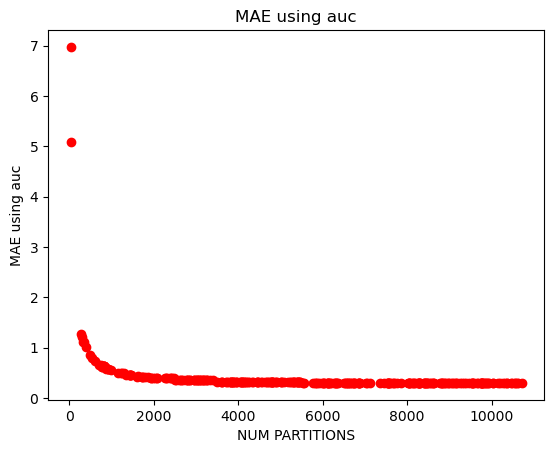

In [57]:
# Get p values (only the ones which were considered
x = np.where(history_mae_auc != np.inf)[0]
# Get MAE values with AUC
y = history_mae_auc[history_mae_auc != np.inf]
 
# Plot
plt.title("MAE using auc") 
plt.xlabel("NUM PARTITIONS") 
plt.ylabel("MAE using auc") 
plt.scatter(x, y, color ="red") 
plt.show()

Plot MAE with Recall over each considered partition.

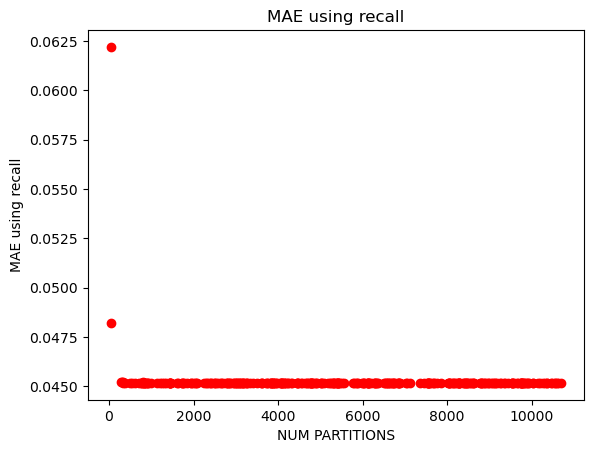

In [56]:
# Get p values (only the ones which were considered)
x = np.where(history_mae_recall != np.inf)
# Get MAE values with recall
y = history_mae_recall[history_mae_recall != np.inf]
 
# Plot
plt.title("MAE using recall") 
plt.xlabel("NUM PARTITIONS") 
plt.ylabel("MAE using recall") 
plt.scatter(x, y, color ="red") 
plt.show()

Plot the bound over each considered partition.

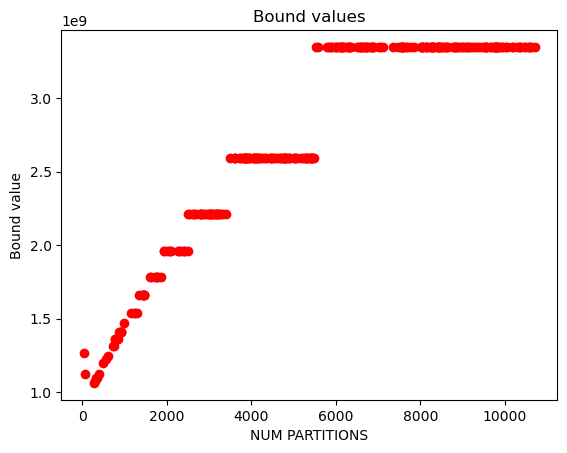

In [32]:
# Get p values (only the ones which were considered)
x = np.where(history_bound != np.inf)
# Get the bound values
y = history_bound[history_bound != np.inf]
 
# Plot
plt.title("Bound values") 
plt.xlabel("NUM PARTITIONS") 
plt.ylabel("Bound value") 
plt.scatter(x, y, color ="red") 
plt.show()

Now finally compute the evaluation with the Stratified estimator.

In [33]:
# Compute Stratified results
for gamma in GAMMAS:
    key = "STRATIFIED_" + str(gamma).replace(".","")
    unbiased_results[key] = stratified(OUTPUT_PREFIX+"-test-pos-unbiased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-unbiased_evaluate_partial.pickle", output_name+"training_arr.npy", propensities[gamma], K=1, partition=best_partition)
    biased_results[key] = stratified(OUTPUT_PREFIX+"-test-pos-biased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-biased_evaluate_partial.pickle", output_name+"training_arr.npy", propensities[gamma], K=30, partition=best_partition)

This version builds a partition evenly distributing the items instead of the propensities.

In [34]:
# Compute Stratified results with the second version
for gamma in GAMMAS:
    key = "STRATIFIED_v2_" + str(gamma).replace(".","")
    unbiased_results[key] = stratified_2(OUTPUT_PREFIX+"-test-pos-unbiased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-unbiased_evaluate_partial.pickle", output_name+"training_arr.npy", propensities[gamma], K=1, partition=best_partition)
    biased_results[key] = stratified_2(OUTPUT_PREFIX+"-test-pos-biased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-biased_evaluate_partial.pickle", output_name+"training_arr.npy", propensities[gamma], K=30, partition=best_partition)


Prepare table for results.

In [35]:
# Set number of columns as number of estimators which were used
columns = len(biased_results.keys())

# Determine the maximum number (number of used metrics)
rows = max(max(len(biased_results[key].keys()) for key in biased_results.keys()), max(len(unbiased_results[key].keys()) for key in unbiased_results.keys()))

# Init matrix to store results
results_array = np.zeros((rows,columns))

# Get the names of the rows
list_biased_res = list(biased_results.keys())

Fill the table with the MAE results and get the DataFrame object.

In [36]:
# For each evaluator
for i in range(len(list_biased_res)):
    key = list_biased_res[i]

    # For each metric
    for j in range(len(list(biased_results[key].keys()))):
        key_2 = list(biased_results[key].keys())[j]

        # Compute MAE between biased and unbiased results
        results_array[j][i] = abs(biased_results[key][key_2] - unbiased_results[key][key_2])

# Make it a DataFrame
mae_df = pd.DataFrame(columns=list(biased_results.keys()), data=results_array)
metric_values = list(biased_results[list(biased_results.keys())[0]].keys())
mae_df.insert(0, "metric", metric_values)

# **RESULTS**

## Visualize

Remembering that...

In [37]:
# Print the results
print("Minimization was done for gamma = ", opt_gamma, ". The best number of partitions: ", best_partition)

Minimization was done for gamma =  1.5 . The best number of partitions:  275


Visualize.

In [38]:
# Visualize
mae_df.head()

,metric,AOA,UB_15,UB_2,UB_25,UB_3,STRATIFIED_15,STRATIFIED_2,STRATIFIED_25,STRATIFIED_3,STRATIFIED_v2_15,STRATIFIED_v2_2,STRATIFIED_v2_25,STRATIFIED_v2_3
0,auc,0.157242,0.277630,0.291807,0.299221,0.302536,1.274450e+00,5.345675e+00,2.527286e+01,1.046531e+02,2.745780e-01,2.863730e-01,2.907798e-01,2.905282e-01
1,recall,0.245840,0.045191,0.034429,0.027800,0.023599,4.522757e-02,3.451006e-02,3.593815e-02,4.209751e-01,4.564295e-02,3.484887e-02,2.820375e-02,2.400030e-02
2,bias,0.000000,0.000000,0.000000,0.000000,0.000000,8.915821e+07,4.126510e+08,2.273189e+09,1.276307e+10,6.127112e+05,7.468088e+05,8.876299e+05,1.037012e+06
3,concentration,0.000000,0.000000,0.000000,0.000000,0.000000,4.869803e+08,3.192107e+09,2.011901e+10,1.277398e+11,5.347297e+08,3.649258e+09,2.503355e+10,1.723566e+11
